# 动量法 --- 从0开始



在[梯度下降和随机梯度下降](./gd-sgd-scratch.md)的章节中，我们介绍了梯度下降算法：每次迭代时，该算法沿着目标函数下降最**快**的方向更新参数。因此，梯度下降有时也叫做最陡下降（steepest descent）。在梯度下降中，每次更新参数的方向仅仅取决当前位置，这可能会带来一些问题。


## 梯度下降的问题

考虑一个输入为二维向量$\mathbf{x} = [x_1, x_2]^\top$，输出为标量的目标函数$f: \mathbb{R}^2 \rightarrow \mathbb{R}$。下面为该函数的等高线示意图（每条等高线表示相同函数值的点：越靠近中间函数值越小）。

![](../img/gd-move.png)

上图中，红色三角形代表参数$\mathbf{x}$的初始值。带箭头的线段表示每次迭代时参数的更新。由于目标函数在竖直方向（$x_2$轴方向）上比在水平方向（$x_1$轴方向）弯曲得更厉害，梯度下降迭代参数时会使参数在竖直方向比在水平方向移动更猛烈。因此，我们需要一个较小的学习率从而避免参数在竖直方向上overshoot。这就造成了上图中参数向最优解移动速度的缓慢。


## 动量法

动量法的提出是为了应对梯度下降的上述问题。广义上，以小批量随机梯度下降为例（当批量大小等于训练集大小时，该算法即为梯度下降；批量大小为1即为随机梯度下降），我们对[梯度下降和随机梯度下降](./gd-sgd-scratch.md)的章节中的小批量随机梯度算法做如下修改：

\begin{align*}
\mathbf{v} &:= \gamma \mathbf{v} + \eta \nabla f_\mathcal{B}(\mathbf{x}),\\
\mathbf{x} &:= \mathbf{x} - \mathbf{v},
\end{align*}

其中$\mathbf{v}$是当前速度，$\gamma$是动量参数。其余符号如学习率$\eta$、有关小批量$\mathcal{B}$的随机梯度$\nabla f_\mathcal{B}(\mathbf{x})$都已在[梯度下降和随机梯度下降](./gd-sgd-scratch.md)的章节中定义，此处不再赘述。

当前速度$\mathbf{v}$的更新可以理解为对$[\eta / (1 - \gamma)] \nabla f_\mathcal{B}(\mathbf{x})$做指数加权移动平均。因此，动量法的每次迭代中，参数在各个方向上移动幅度不仅取决当前梯度，还取决过去各个梯度在各个方向上是否一致。当过去的所有梯度都在同一方向，例如都是水平向右，那么参数在水平向右的移动幅度最大。如果过去的梯度中在竖直方向上时上时下，那么参数在竖直方向的移动幅度将变小。这样，我们就可以使用较大的学习率，从而如下图收敛更快。

![](../img/momentum-move.png)


## 动量参数

为了有助于理解动量参数$\gamma$，让我们考虑一个简单的问题：每次迭代的小批量随机梯度$\nabla f_\mathcal{B}(\mathbf{x})$都等于$\mathbf{g}$。由于所有小批量随机梯度都在同一方向，动量法在该方向使参数移动加速：

\begin{align*}
\mathbf{v}_1 &:= \eta\mathbf{g},\\
\mathbf{v}_2 &:= \gamma \mathbf{v}_1 + \eta\mathbf{g} = \eta\mathbf{g} (\gamma + 1),\\
\mathbf{v}_3 &:= \gamma \mathbf{v}_2 + \eta\mathbf{g} = \eta\mathbf{g} (\gamma^2 + \gamma + 1),\\
&\ldots\\
\mathbf{v}_{\inf} &:= \frac{\eta\mathbf{g}}{1 - \gamma}.
\end{align*}

例如，当$\gamma = 0.99$, 最终的速度将是学习率乘以相应小批量随机梯度$\eta\mathbf{g}$的100倍大。

## 算法实现和实验

动量法的实现也很简单。我们在小批量随机梯度下降的基础上添加速度项。

In [1]:
# 动量法。
def sgd_momentum(params, vs, lr, mom, batch_size):
    for param, v in zip(params, vs):
        v[:] = mom * v + lr * param.grad / batch_size
        param[:] -= v

实验中，我们以线性回归为例。其中真实参数`w`为[2, -3.4]，`b`为4.2。我们把速度项初始化为和参数形状相同的零张量。

In [2]:
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    for param in params:
        param.attach_grad()
        # 把速度项初始化为和参数形状相同的零张量。
        vs.append(param.zeros_like())
    return params, vs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

接下来定义训练函数。当epoch大于2时（epoch从1开始计数），学习率以自乘0.1的方式自我衰减。训练函数的period参数说明，每次采样过该数目的数据点后，记录当前目标函数值用于作图。例如，当period和batch_size都为10时，每次迭代后均会记录目标函数值。

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 重设学习率。
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            sgd_momentum([w, b], vs, lr, mom, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

使用动量法，最终学到的参数值与真实值较接近。

Batch size 10, Learning rate 0.200000, Epoch 1, loss 1.7184e-03
Batch size 10, Learning rate 0.200000, Epoch 2, loss 5.3015e-05


Batch size 10, Learning rate 0.020000, Epoch 3, loss 4.9890e-05
w: [[ 2.00137234 -3.40014625]] b: 4.20205 



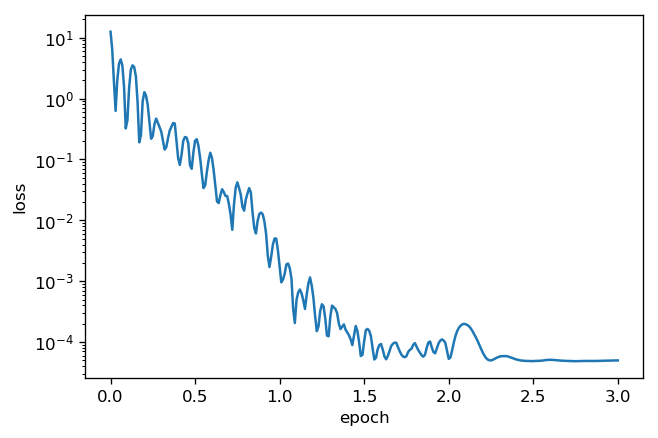

In [4]:
train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

## 结论

* 动量法可以提升随机梯度下降，例如对于某些问题可以选用较大学习率从而加快收敛。


## 练习

* 试着使用较小的动量参数，观察实验结果。

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/1879)